Epoch 1/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.5960 - val_loss: 0.1356
Epoch 2/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2635 - val_loss: 0.1030
Epoch 3/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2153 - val_loss: 0.0924
Epoch 4/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1701 - val_loss: 0.0895
Epoch 5/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1375 - val_loss: 0.0834
Epoch 6/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1189 - val_loss: 0.0785
Epoch 7/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1011 - val_loss: 0.0800
Epoch 8/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0927 - val_loss: 0.0735
Epoch 9/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0903 - val_loss: 0.0719
Epoch 10/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0861 - val_loss: 0.0698
Epoch 11/50
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0853 - val_loss: 0.0699
Epoch 12/50
1891/1891 ━━━━━

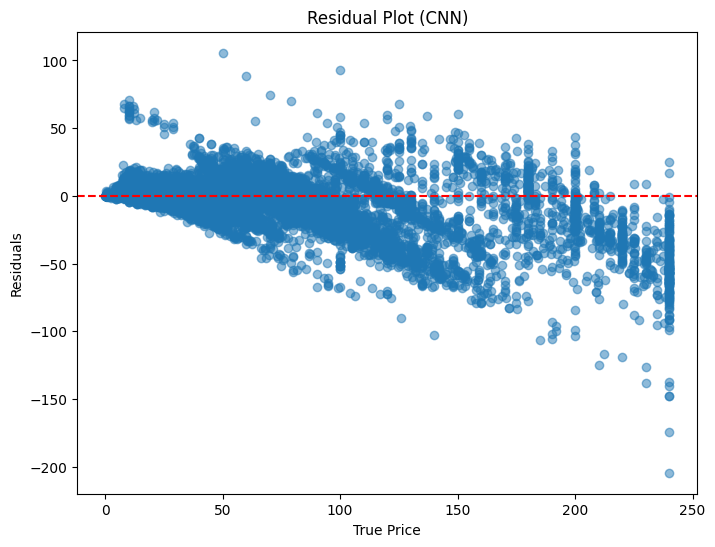

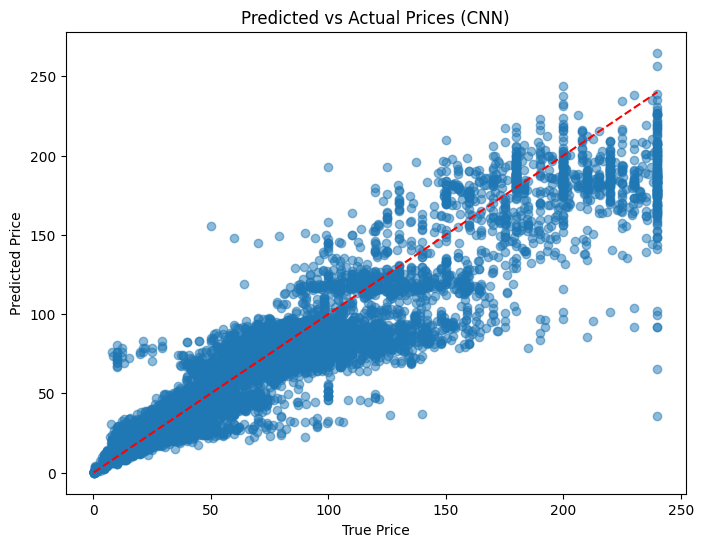

In [3]:
!pip install -q category_encoders
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Utility Functions ---
def preprocess_target(y, clip_percentile=99.0):
    y_clipped = np.clip(y, 1e-6, np.percentile(y, clip_percentile))
    return np.log1p(y_clipped)

def inverse_preprocess_target(y): return np.expm1(y)

def cyclical_encode_month(df, col='mp_month'):
    df[f'{col}_sin'] = np.sin(2 * np.pi * (df[col] - 1) / 12)
    df[f'{col}_cos'] = np.cos(2 * np.pi * (df[col] - 1) / 12)
    return df

def remove_outliers(df, column='mp_price', iqr_multiplier=1.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_multiplier * IQR
    upper = Q3 + iqr_multiplier * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)].reset_index(drop=True)

# --- Load and preprocess ---
df = pd.read_csv("wfp_food_prices_database.csv", low_memory=False)
df = df.drop(columns=["mp_commoditysource", "adm0_name", "adm1_name", "mkt_name", "cur_name", "pt_name", "um_name"], errors='ignore')
df = df[df["mp_price"] > 0].reset_index(drop=True)
df = remove_outliers(df)
df = cyclical_encode_month(df)
df["adm1_mean_price"] = df.groupby("adm1_id")["mp_price"].transform("mean")

# Convert categorical columns to strings
for col in ["adm1_id", "cm_id", "cur_id", "pt_id", "um_id"]:
    df[col] = df[col].astype(str)

# --- Features and Target ---
X = df[[
    "adm1_id", "cm_id", "cm_name", "cur_id", "pt_id", "um_id",
    "mp_month_sin", "mp_month_cos", "mp_year", "adm1_mean_price"
]]
y = preprocess_target(df["mp_price"])

cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes(["int64", "float64"]).columns.tolist()

# --- Preprocessing Pipeline ---
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", TargetEncoder(min_samples_leaf=5, smoothing=10.0), cat_cols)
])
X_processed = preprocessor.fit_transform(X, y)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# --- Reshape for CNN ---
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# --- CNN Model ---
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# --- Training ---
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
start_time = time.time()
model.fit(
    X_train_cnn, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
training_time = time.time() - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")

# --- Evaluation ---
y_pred = model.predict(X_test_cnn).flatten()
y_pred_orig = inverse_preprocess_target(y_pred)
y_test_orig = inverse_preprocess_target(y_test)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
mae = np.mean(np.abs(y_test_orig - y_pred_orig))

print(f"\n📊 Test Results:\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

# --- Plot Residuals ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig - y_test_orig, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Price")
plt.ylabel("Residuals")
plt.title("Residual Plot (CNN)")
plt.show()

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices (CNN)")
plt.show()
